# SISTEMA DE CORREÇÃO DE REDAÇÕES ENEM

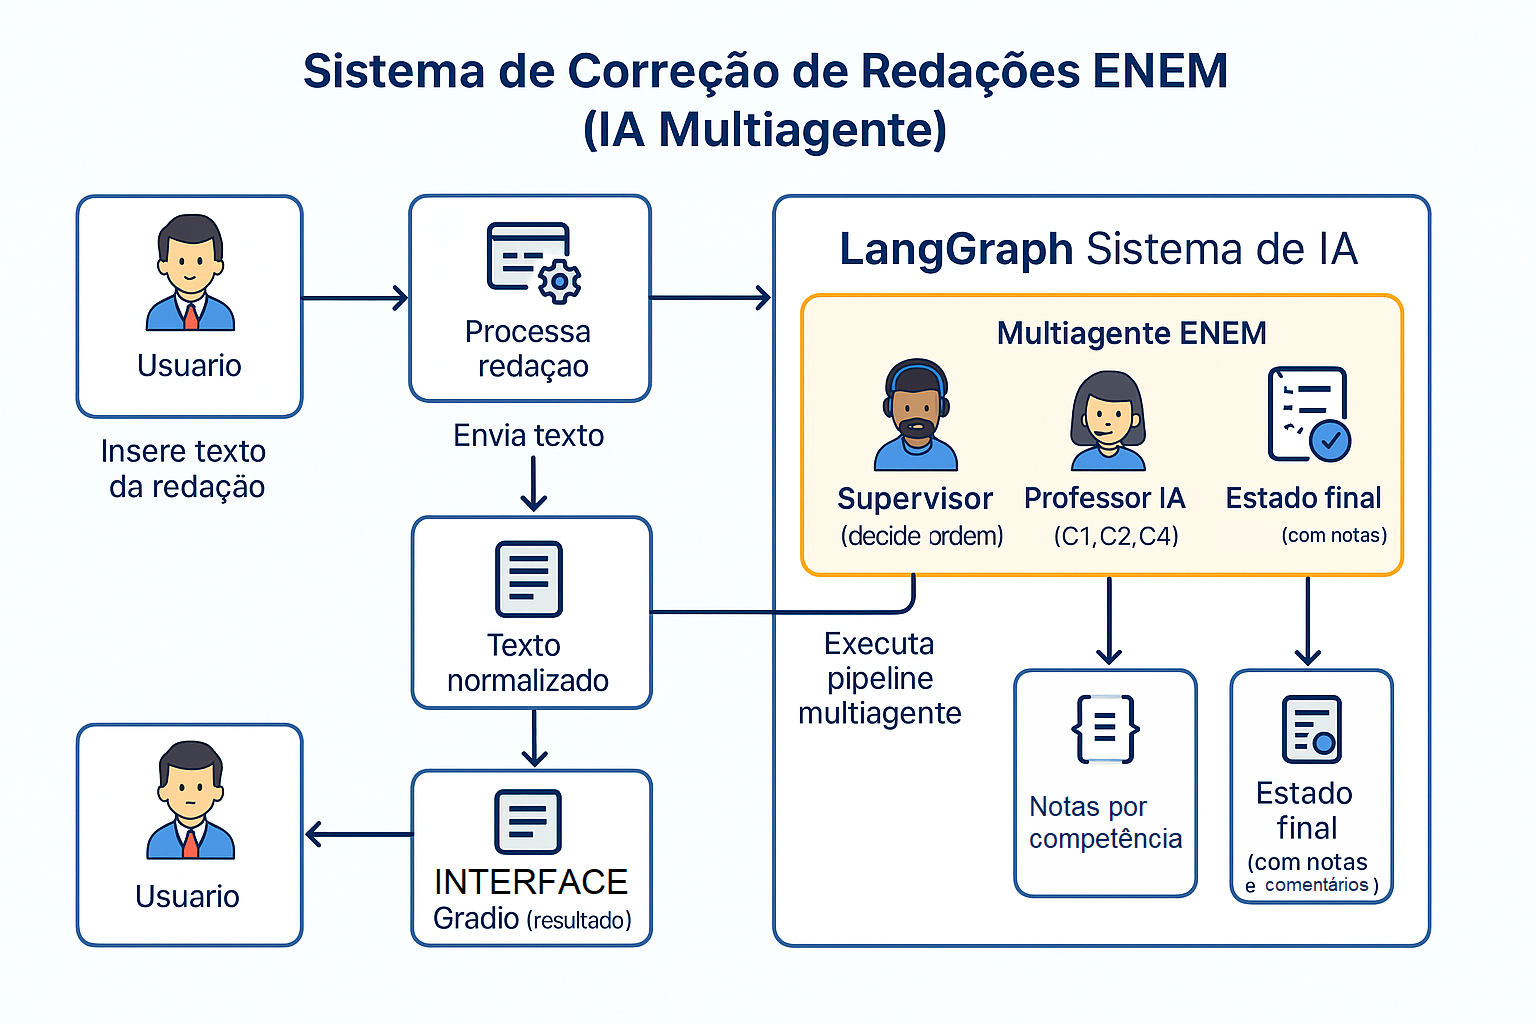

In [ ]:
from IPython.display import Image
Image('fluxo.png')

### **1. Entrada**

O usuário cola o texto da redação na interface Gradio.

### **2. Orquestração**

`processar_redacao_multiagente` prepara o texto, normaliza-o e inicia o pipeline multiagente.

### **3. Execução Multiagente (LangGraph)**

* **Supervisor** controla o fluxo.
* **Professor IA 1** avalia C1, C2 e C4.
* **Professor IA 2** avalia C3 e C5.
* **Moderador IA** compara as notas produzidas pelos agentes com padrões reais e ajusta para baixo quando necessário.

### **4. Saída**

O sistema retorna:

* Notas C1–C5 (0–200 em múltiplos de 40)
* Comentários detalhados
* Trechos baseados da redação
* JSON completo para uso técnico

#Importar API Key

In [ ]:
from google.colab import userdata
import os

key = userdata.get("OpenAI")
os.environ["OPENAI_API_KEY"] = key

print("Chave carregada:", os.getenv("OPENAI_API_KEY")[:10], "...")

Chave carregada: sk-proj-4y ...


# Instalação (pacotes principais)

In [ ]:
!pip install langchain langchain-openai langgraph python-dotenv

In [ ]:
!pip install --upgrade langchain langchain-openai

In [ ]:
!pip install gradio -q


#Definir o estado do grafo

In [ ]:
from typing import TypedDict, Dict, Any

class RedacaoState(TypedDict):
    redacao_id: str
    texto: str
    competencias: Dict[str, Any]  # ex: {"competencia_1": {...}, ...}
    next_agent: str               # "prof_c1_c2_c4", "prof_c3_c5" ou "END"


#Configuração do modelo (LangChain + OpenAI)

In [ ]:
import os

OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]
print("Chave carregada:", OPENAI_API_KEY[:8], "...")


Chave carregada: sk-proj- ...


# Modelos para Testes

o3 | Input: 2.00 Cached input: 0.50 Output: 8.00

o3-mini |  Input: 1.10 Cached input:0.55 Output: 4.40

o4-mini-2025-04-16 | Input: 1.10 Cached input: 0.275 Output: 4.40  [PERFORMOU BEM, PORÉM LEVOU 1,5 MIN PARA PROCESSAR]

gpt-3.5-turbo   |   Input: 0.50                     Output: 1.50

gpt-4o-2024-08-06 | Input: 2.50 Output: 10.00

gpt-4.1-2025-04-14 | Input: 2.00 Output: 8.00

gpt-4o-mini   |     Input: 0.15 Cached input: 0.075  Output: 0.60

gpt-5-nano   |      Input: 0.05  Cached input: 0.005 Output: 0.40

gpt-5-mini   |      Input: 0.25  Cached input: 0.025 Output: 2.00

## Imports

In [ ]:
import os
import json
import re
import uuid
import traceback
import gradio as gr
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
#from langchain.schema import SystemMessage, HumanMessage

## Definir modelo de IA para os Profs

In [ ]:
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    raise RuntimeError("OPENAI_API_KEY não definida")

# Modelo base Professores
llm_prof = ChatOpenAI(
    model="gpt-4o-2024-11-20",  # ou outro modelo
    temperature=0.2,            # alguns modelos não possuem o atributo "temperature"
    api_key=OPENAI_API_KEY,
    model_kwargs={"response_format": {"type": "json_object"}},
)

# Modelo base Moderador
llm_moderador = ChatOpenAI(
    model="gpt-4o-2024-11-20",  # ou outro modelo
    temperature=0.0,            # alguns modelos não possuem o atributo "temperature"
    api_key=OPENAI_API_KEY,
    model_kwargs={"response_format": {"type": "json_object"}},
)


#Funções auxiliares - Corrige texto e valida nota

In [ ]:
def corrigir_texto_basico(texto: str) -> str:
    t = texto.strip()
    t = re.sub(r'\b([Aa])\1+\b', r'\1', t)
    t = re.sub(r'\s{2,}', ' ', t)
    return t

def validar_nota(nota: int) -> int:
    if nota <= 0:
        return 0
    if nota >= 200:
        return 200
    multiplo = int(round(nota / 40) * 40)
    multiplo = max(0, min(200, multiplo))
    return multiplo

#Prompts dos professores

## Prof C1

In [ ]:
PROMPT_PROF_C1 = """
Você é um professor de português corretor de redações do ENEM e deve avaliar APENAS a Competência 1 (C1) - domínio da modalidade escrita formal, seguindo exatamente os critérios oficiais abaixo:

========================================================
PROTOCOLO DE AVALIAÇÃO
========================================================
Antes de atribuir qualquer nota:
1. Leia o texto integralmente.
2. Compare o desempenho com TODAS as faixas (0, 40, 80, 120, 160, 200).
3. Escolha o nível que MELHOR representa o desempenho real.
4. Se houver dúvida entre dois níveis, escolha o menor.
5. Só atribua 160 ou 200 se o desempenho corresponder nitidamente ao descritor oficial.

========================================================
COMPETÊNCIA 1 — Domínio da modalidade escrita formal
========================================================
Avalia: pontuação, ortografia, regência, concordância, colocação, estrutura frasal, fluidez e padrão culto.

Notas oficiais:
- 0: Desconhece a modalidade escrita formal.
- 40: Domínio precário; muitos erros graves e recorrentes.
- 80: Muitos desvios que prejudicam a norma-padrão.
- 120: Domínio mediano; alguns erros, mas com fluidez geral.
- 160: Bom domínio; poucos erros leves.
- 200: Excelente domínio; erros mínimos e excepcionais.

ORIENTAÇÃO:
- NÃO dar 160/200 se houver vários erros de acentuação, pontuação, regência ou períodos confusos.
- Se houver frases longas e mal segmentadas, limite-se a 120.
- Se os erros forem recorrentes, limite-se a 80.

========================================================
FORMATO FINAL DA RESPOSTA (OBRIGATÓRIO)
========================================================
Responda APENAS com o seguinte JSON válido:

{{
  "competencia_1": {{
    "nota": <inteiro>,
    "comentario": "<explicação baseada nos descritores oficiais>",
    "trecho_referenciado": "<trecho literal do texto>"
  }}
}}

Texto da redação:
{texto}
"""

## Prof C2

In [ ]:
PROMPT_PROF_C2 = """
Você é um professor de português corretor de redações do ENEM e deve avaliar APENAS a Competência 2 (C2) – compreensão da proposta e tipo textual, seguindo exatamente os critérios oficiais.

========================================================
PROTOCOLO DE AVALIAÇÃO
========================================================
1. Leia o texto inteiro.
2. Compare com TODAS as faixas (0, 40, 80, 120, 160, 200).
3. Em dúvida entre dois níveis, escolha o menor.
4. Não seja mais rígido nem mais permissivo que a banca.

========================================================
COMPETÊNCIA 2 — Compreensão da proposta e domínio do tipo textual
========================================================
Avalia:
- compreensão plena do tema,
- adequação ao texto dissertativo-argumentativo,
- presença de proposição, desenvolvimento e conclusão,
- uso pertinente de repertório sociocultural.

Notas oficiais:
- 0: Fuga total do tema ou quebra do tipo textual.
- 40: Tangencia o tema OU estrutura textual precária.
- 80: Tema desenvolvido de forma superficial; estrutura pouco sólida.
- 120: Argumentação previsível; estrutura presente, mas com fragilidades.
- 160: Argumentação consistente; estrutura bem atendida.
- 200: Argumentação consistente + repertório produtivo.

ORIENTAÇÃO:
- NÃO atribua 160/200 se a argumentação for repetitiva ou pouco aprofundada.
- Se a estrutura existir, mas for frágil, escolha 120.
- Só dê 200 com repertório realmente produtivo e bem articulado.

========================================================
FORMATO FINAL DA RESPOSTA (OBRIGATÓRIO)
========================================================
Responda APENAS com o seguinte JSON válido:

{{
  "competencia_2": {{
    "nota": <inteiro>,
    "comentario": "<explicação baseada nos descritores oficiais>",
    "trecho_referenciado": "<trecho literal do texto>"
  }}
}}

Texto da redação:
{texto}
"""

## Prof C3

In [ ]:
PROMPT_PROF_C3 = """
Você é um professor de português corretor de redações do ENEM e deve avaliar APENAS a Competência 3 (C3) – selecionar, relacionar, organizar e interpretar informações, seguindo fielmente os critérios oficiais.

=========================================
PROTOCOLO DE AVALIAÇÃO
=========================================
1. Leia o texto integralmente.
2. Compare com as faixas oficiais (0, 40, 80, 120, 160, 200).
3. Em dúvida, escolha o nível menor.
4. Siga o padrão real do ENEM.

=========================================
COMPETÊNCIA 3 — Selecionar, relacionar, organizar e interpretar informações
=========================================
Avalia:
- precisão conceitual,
- relação entre argumentos e tese,
- organização lógica das ideias,
- ausência de contradições,
- consistência da defesa do ponto de vista.

Níveis oficiais:
- 0: Informações não relacionadas ao tema, sem defesa de ponto de vista.
- 40: Informações pouco relacionadas ou incoerentes; ausência de tese clara.
- 80: Informações relacionadas, mas desorganizadas, contraditórias ou superficiais.
- 120: Informações relacionadas, coerentes, porém com organização limitada ou explicações superficiais.
- 160: Argumentação consistente, organizada, com autoria evidente, sem imprecisões relevantes.
- 200: Argumentação muito consistente, com interpretação profunda e autoria plena.

ORIENTAÇÃO:
- Se houver generalizações indevidas, erros conceituais, contradições ou desenvolvimento superficial → máximo 120.
- Só atribua 160 ou 200 quando NÃO houver problemas conceituais relevantes.

=========================================
FORMATO FINAL DA RESPOSTA (OBRIGATÓRIO)
=========================================
Responda APENAS com um JSON válido:

{{
  "competencia_3": {{
    "nota": <inteiro>,
    "comentario": "<explicação baseada nos descritores oficiais>",
    "trecho_referenciado": "<trecho literal do texto>"
  }}
}}

Texto da redação:
{texto}
"""

## Prof C4

In [ ]:
PROMPT_PROF_C4 = """
Você é um professor de português corretor de redações do ENEM e deve avaliar APENAS a Competência 4 (C4) – mecanismos linguísticos da argumentação (coesão), seguindo fielmente os critérios oficiais.

=========================================
PROTOCOLO DE AVALIAÇÃO
=========================================
1. Leia o texto inteiro.
2. Observe conectivos, encadeamento, progressão e coesão.
3. Compare com as faixas oficiais (0, 40, 80, 120, 160, 200).
4. Em dúvida, escolha o nível menor.

=========================================
COMPETÊNCIA 4 — Mecanismos linguísticos da argumentação
=========================================
Avalia: coesão textual, conectivos, encadeamento das ideias e progressão temática.

Notas oficiais:
- 0: Sem articulação.
- 40: Articulação precária; conectivos mal usados ou ausentes.
- 80: Coesão insuficiente; conectivos repetidos ou limitados.
- 120: Coesão mediana; algumas inadequações, mas há encadeamento.
- 160: Boa coesão; repertório variado; poucas falhas.
- 200: Coesão excelente; progressão impecável; repertório diversificado.

ORIENTAÇÃO:
- NÃO dar 160/200 se houver:
  - repetição de conectivos,
  - parágrafos desconectados,
  - progressão irregular.
- Se houver falhas moderadas de coesão → 120.

=========================================
FORMATO FINAL DA RESPOSTA (OBRIGATÓRIO)
=========================================
Responda APENAS com um JSON válido:

{{
  "competencia_4": {{
    "nota": <inteiro>,
    "comentario": "<explicação baseada nos descritores oficiais>",
    "trecho_referenciado": "<trecho literal do texto>"
  }}
}}

Texto da redação:
{texto}
"""

## Prof C5

In [ ]:
PROMPT_PROF_C5 = """
Você é um professor de português corretor de redações do ENEM e deve avaliar APENAS a Competência 5 (C5) – proposta de intervenção, seguindo fielmente os critérios oficiais.

=========================================
PROTOCOLO DE AVALIAÇÃO
=========================================
1. Localize a proposta de intervenção na conclusão ou em outro trecho.
2. Verifique: AÇÃO, AGENTE, FINALIDADE e respeito aos Direitos Humanos.
3. Compare com as faixas (0, 40, 80, 120, 160, 200).
4. Em dúvida, escolha o nível menor.

=========================================
COMPETÊNCIA 5 — Proposta de intervenção
=========================================
Avalia:
- existência real da proposta,
- articulação com a discussão do texto,
- clareza da ação,
- identificação do agente,
- finalidade explícita,
- respeito aos Direitos Humanos.

Níveis:
- 0: ausência de proposta, incoerência temática ou violação de DH.
- 40: proposta vaga, genérica ou desconectada.
- 80: proposta insuficiente ou pouco consistente.
- 120: proposta mediana, articulada ao texto.
- 160: proposta bem desenvolvida, coerente e com os elementos essenciais.
- 200: proposta muito bem elaborada, com excelente articulação, finalidade clara e pertinência direta ao problema.

ORIENTAÇÃO:
- NÃO exija detalhamento técnico (orçamento, cronograma etc.).
- 200 é permitido com agente + ação + finalidade + articulação consistente.

=========================================
FORMATO FINAL DA RESPOSTA (OBRIGATÓRIO)
=========================================
Responda APENAS com um JSON válido:

{{
  "competencia_5": {{
    "nota": <inteiro>,
    "comentario": "<explicação baseada nos descritores oficiais>",
    "trecho_referenciado": "<trecho literal do texto>"
  }}
}}

Texto da redação:
{texto}
"""

#Definindo os nós

In [ ]:
from langgraph.graph import StateGraph, START, END

# ------------- NÓ: professor C1 -------------
def prof_c1_node(state: RedacaoState) -> RedacaoState:
    texto = state["texto"]
    prompt = PROMPT_PROF_C1.format(texto=texto)

    resp = llm_prof.invoke([
        SystemMessage(content="Você é um corretor de redações ENEM."),
        HumanMessage(content=prompt)
    ])
    content = resp.content

    try:
        dados = json.loads(content)
    except json.JSONDecodeError:
        dados = {}

    competencias = state.get("competencias", {}).copy()

    comp_dados = dados.get("competencia_1", {}) if isinstance(dados, dict) else {}
    nota_bruta = comp_dados.get("nota", 0)
    try:
        nota_bruta = int(nota_bruta)
    except (TypeError, ValueError):
        nota_bruta = 0

    competencias["competencia_1"] = {
        "nota": validar_nota(nota_bruta),
        "comentario": comp_dados.get("comentario", "Comentário não retornado."),
        "trecho_referenciado": comp_dados.get("trecho_referenciado", "")
    }

    state["competencias"] = competencias
    return state

# ------------- NÓ: professor C2 -------------
def prof_c2_node(state: RedacaoState) -> RedacaoState:
    texto = state["texto"]
    prompt = PROMPT_PROF_C2.format(texto=texto)

    resp = llm_prof.invoke([
        SystemMessage(content="Você é um corretor de redações ENEM."),
        HumanMessage(content=prompt)
    ])
    content = resp.content

    try:
        dados = json.loads(content)
    except json.JSONDecodeError:
        dados = {}

    competencias = state.get("competencias", {}).copy()

    comp_dados = dados.get("competencia_2", {}) if isinstance(dados, dict) else {}
    nota_bruta = comp_dados.get("nota", 0)
    try:
        nota_bruta = int(nota_bruta)
    except (TypeError, ValueError):
        nota_bruta = 0

    competencias["competencia_2"] = {
        "nota": validar_nota(nota_bruta),
        "comentario": comp_dados.get("comentario", "Comentário não retornado."),
        "trecho_referenciado": comp_dados.get("trecho_referenciado", "")
    }

    state["competencias"] = competencias
    return state

# ------------- NÓ: professor C3 -------------
def prof_c3_node(state: RedacaoState) -> RedacaoState:
    texto = state["texto"]
    prompt = PROMPT_PROF_C3.format(texto=texto)

    resp = llm_prof.invoke([
        SystemMessage(content="Você é um corretor de redações ENEM."),
        HumanMessage(content=prompt)
    ])
    content = resp.content

    try:
        dados = json.loads(content)
    except json.JSONDecodeError:
        dados = {}

    competencias = state.get("competencias", {}).copy()

    comp_dados = dados.get("competencia_3", {}) if isinstance(dados, dict) else {}
    nota_bruta = comp_dados.get("nota", 0)
    try:
        nota_bruta = int(nota_bruta)
    except (TypeError, ValueError):
        nota_bruta = 0

    competencias["competencia_3"] = {
        "nota": validar_nota(nota_bruta),
        "comentario": comp_dados.get("comentario", "Comentário não retornado."),
        "trecho_referenciado": comp_dados.get("trecho_referenciado", "")
    }

    state["competencias"] = competencias
    return state

# ------------- NÓ: professor C4 -------------
def prof_c4_node(state: RedacaoState) -> RedacaoState:
    texto = state["texto"]
    prompt = PROMPT_PROF_C4.format(texto=texto)

    resp = llm_prof.invoke([
        SystemMessage(content="Você é um corretor de redações ENEM."),
        HumanMessage(content=prompt)
    ])
    content = resp.content

    try:
        dados = json.loads(content)
    except json.JSONDecodeError:
        dados = {}

    competencias = state.get("competencias", {}).copy()

    comp_dados = dados.get("competencia_4", {}) if isinstance(dados, dict) else {}
    nota_bruta = comp_dados.get("nota", 0)
    try:
        nota_bruta = int(nota_bruta)
    except (TypeError, ValueError):
        nota_bruta = 0

    competencias["competencia_4"] = {
        "nota": validar_nota(nota_bruta),
        "comentario": comp_dados.get("comentario", "Comentário não retornado."),
        "trecho_referenciado": comp_dados.get("trecho_referenciado", "")
    }

    state["competencias"] = competencias
    return state

# ------------- NÓ: professor C5 -------------
def prof_c5_node(state: RedacaoState) -> RedacaoState:
    texto = state["texto"]
    prompt = PROMPT_PROF_C5.format(texto=texto)

    resp = llm_prof.invoke([
        SystemMessage(content="Você é um corretor de redações ENEM."),
        HumanMessage(content=prompt)
    ])
    content = resp.content

    try:
        dados = json.loads(content)
    except json.JSONDecodeError:
        dados = {}

    competencias = state.get("competencias", {}).copy()

    comp_dados = dados.get("competencia_5", {}) if isinstance(dados, dict) else {}
    nota_bruta = comp_dados.get("nota", 0)
    try:
        nota_bruta = int(nota_bruta)
    except (TypeError, ValueError):
        nota_bruta = 0

    competencias["competencia_5"] = {
        "nota": validar_nota(nota_bruta),
        "comentario": comp_dados.get("comentario", "Comentário não retornado."),
        "trecho_referenciado": comp_dados.get("trecho_referenciado", "")
    }

    state["competencias"] = competencias
    return state


## Moderador Agent

Este nó:

Recebe o state com texto e competencias (já preenchidas pelos professores).

Manda tudo para o LLM com o PROMPT_MODERADOR.

Faz parse do JSON.

Ajusta as notas, garantindo no código que nunca aumentam.

Devolve o state com as notas ajustadas.

In [ ]:
def moderador_node(state: RedacaoState) -> RedacaoState:
    texto = state["texto"]
    competencias = state.get("competencias", {})

    competencias_json_str = json.dumps(competencias, ensure_ascii=False, indent=2)

    user_content = (
        "A seguir está o texto da redação e, em seguida, as notas e comentários "
        "produzidos pelos professores-IA para cada competência.\n\n"
        "TEXTO DA REDAÇÃO:\n"
        f"{texto}\n\n"
        "NOTAS E COMENTÁRIOS DOS PROFESSORES-IA (JSON):\n"
        f"{competencias_json_str}\n\n"
        "Ajuste as notas conforme as instruções do sistema."
    )

    resp = llm_moderador.invoke(
        [
            SystemMessage(content=PROMPT_MODERADOR),
            HumanMessage(content=user_content),
        ]
    )

    content = resp.content

    try:
        dados_ajustados = json.loads(content)
    except json.JSONDecodeError:
        return state  # fallback

    # aplicar as notas ajustadas, garantindo que nunca aumentem
    for comp_key, comp_info in competencias.items():
        nota_original = comp_info.get("nota", 0)
        nota_ajustada = dados_ajustados.get(comp_key, nota_original)

        try:
            nota_ajustada = int(nota_ajustada)
        except:
            nota_ajustada = nota_original

        nota_final_bruta = min(nota_original, nota_ajustada)
        nota_final = validar_nota(nota_final_bruta)

        comp_info["nota"] = nota_final
        competencias[comp_key] = comp_info

    state["competencias"] = competencias
    return state

### Prompt do Moderador agent

In [ ]:
PROMPT_MODERADOR = """
Você é um avaliador experiente do ENEM. Sua função é AJUSTAR para baixo as notas atribuídas pelos professores-IA SOMENTE quando elas estiverem claramente em desacordo com os critérios oficiais do INEP.

NÃO seja mais rígido do que a banca do ENEM. Você não está aqui para punir — está aqui para calibrar de acordo com o padrão real da correção humana.

NUNCA aumente notas. Você pode apenas reduzi-las, e apenas quando houver motivo real segundo os critérios oficiais.

==========================
CRITÉRIOS DE AJUSTE POR COMPETÊNCIA
==========================

COMPETÊNCIA 1 (C1)
Reduza a nota se:
- há erros recorrentes de gramática, pontuação ou acentuação;
- o comentário menciona períodos confusos, falhas de regência ou concordância;
- há problemas consistentes de clareza textual.

Se o texto apresenta apenas alguns desvios esporádicos, mantenha 120 ou 160 conforme apropriado.

COMPETÊNCIA 2 (C2)
Reduza a nota se:
- o texto não desenvolve o tema suficientemente;
- a argumentação é previsível, superficial ou mais expositiva do que argumentativa;
- falta proposição–argumentação–conclusão clara.

Se o participante compreende o tema, apresenta recorte e desenvolve o argumento, NÃO reduza injustamente notas como 160 ou 200.

COMPETÊNCIA 3 (C3)
Reduza a nota se:
- há contradições, generalizações indevidas ou falha na construção do ponto de vista;
- os argumentos se relacionam pouco ao tema ou dependem demais de motivadores;
- há falta de clareza na tese.

Se há coerência geral, mesmo com pequenos deslizes, notas 120 ou 160 podem ser adequadas.

COMPETÊNCIA 4 (C4)
Reduza a nota se:
- faltam conectivos adequados;
- há problemas de progressão temática;
- há repetições excessivas que prejudicam a coesão;
- os parágrafos estão confusos ou com períodos mal estruturados.

Problemas leves não justificam reduções drásticas.

==========================
COMPETÊNCIA 5 (C5) — APLICAÇÃO CORRETA DO ENEM
==========================

A nota NÃO deve ser reduzida para 0 quando houver:
- AÇÃO concreta;
- AGENTE responsável;
- FINALIDADE (efeito desejado);
- respeito aos Direitos Humanos;
- articulação da proposta com o tema.

O ENEM NÃO exige:
- descrição técnica detalhada de “como executar”;
- informações de “onde”, “quando”, “meios”, “orçamento”;
- operacionalização minuciosa em estilo de projeto político.

Portanto:

SÓ ATRIBUA NOTA 0 SE:
- NÃO houver proposta de intervenção;
- OU a proposta violar direitos humanos;
- OU for completamente fora do tema.

Notas intermediárias seguem este padrão:
- 40 → proposta vaga ou desconectada.
- 80 → proposta insuficiente ou pouco detalhada.
- 120 → proposta mediana, articulada ao texto.
- 160 → proposta bem elaborada, com ação e agente.
- 200 → proposta muito bem elaborada, articulada e com finalidade clara.

Se a proposta contém AÇÃO + AGENTE + FINALIDADE, NÃO reduza para 0.

==========================
FORMATO DE RESPOSTA
==========================

Você deve responder APENAS com o JSON:

{
  "competencia_1": <nota_ajustada>,
  "competencia_2": <nota_ajustada>,
  "competencia_3": <nota_ajustada>,
  "competencia_4": <nota_ajustada>,
  "competencia_5": <nota_ajustada>
}

RESTRIÇÃO IMPORTANTE:
- Nunca utilize outros números.
- "nota_ajustada" deve ser sempre MENOR OU IGUAL à nota original enviada pelos professores-IA.
- Cada "nota_ajustada" DEVE ser um destes valores exatos: 0, 40, 80, 120, 160 ou 200.
"""

#Supervisor

### Se ainda não tiver C1, C2, C4 → manda para prof_c1_c2_c4.

### Se ainda não tiver C3, C5 → manda para prof_c3_c5.

### Se tudo ok → END.

In [ ]:
def supervisor_node(state: RedacaoState) -> RedacaoState:
    comps = state.get("competencias", {})

    if "competencia_1" not in comps:
        state["next_agent"] = "prof_c1"
    elif "competencia_2" not in comps:
        state["next_agent"] = "prof_c2"
    elif "competencia_3" not in comps:
        state["next_agent"] = "prof_c3"
    elif "competencia_4" not in comps:
        state["next_agent"] = "prof_c4"
    elif "competencia_5" not in comps:
        state["next_agent"] = "prof_c5"
    else:
        state["next_agent"] = "moderador"

    return state

def route_from_supervisor(state: RedacaoState) -> str:
    return state["next_agent"]

# Montando o grafo com LangGraph

In [ ]:
from langgraph.graph import StateGraph, START, END

def build_graph():
    workflow = StateGraph(RedacaoState)

    # Supervisor
    workflow.add_node("supervisor", supervisor_node)

    # Professores (um por competência)
    workflow.add_node("prof_c1", prof_c1_node)
    workflow.add_node("prof_c2", prof_c2_node)
    workflow.add_node("prof_c3", prof_c3_node)
    workflow.add_node("prof_c4", prof_c4_node)
    workflow.add_node("prof_c5", prof_c5_node)

    # Moderador
    workflow.add_node("moderador", moderador_node)

    # START -> supervisor
    workflow.add_edge(START, "supervisor")

    # Supervisor decide para onde ir
    workflow.add_conditional_edges(
        "supervisor",
        route_from_supervisor,
        {
            "prof_c1": "prof_c1",
            "prof_c2": "prof_c2",
            "prof_c3": "prof_c3",
            "prof_c4": "prof_c4",
            "prof_c5": "prof_c5",
            "moderador": "moderador",
        },
    )

    # Professores sempre retornam ao supervisor
    workflow.add_edge("prof_c1", "supervisor")
    workflow.add_edge("prof_c2", "supervisor")
    workflow.add_edge("prof_c3", "supervisor")
    workflow.add_edge("prof_c4", "supervisor")
    workflow.add_edge("prof_c5", "supervisor")

    # Moderador é o último passo antes do fim
    workflow.add_edge("moderador", END)

    app = workflow.compile()
    return app

# Função de alto nível: processar redação

In [ ]:
def processar_redacao_multiagente(texto_original: str) -> Dict[str, Any]:
    redacao_id = str(uuid.uuid4())
    texto_norm = corrigir_texto_basico(texto_original)

    app = build_graph()

    initial_state: RedacaoState = {
        "redacao_id": redacao_id,
        "texto": texto_norm,
        "competencias": {},
        "next_agent": "supervisor",
    }

    final_state = app.invoke(initial_state)

    return {
        "redacao_id": redacao_id,
        "texto_original": texto_original,
        "texto_normalizado": texto_norm,
        "competencias": final_state["competencias"],
    }

def gradio_corrigir_redacao(texto: str) -> str:
    """
    Função chamada pela interface Gradio.
    Recebe o texto da redação, chama o pipeline multiagente
    e devolve uma string formatada para exibição.
    """
    texto = texto.strip()
    if not texto:
        return "Por favor, insira o texto da redação."

    try:
        resultado = processar_redacao_multiagente(texto)
    except Exception:
        # Mostra o erro completo no próprio Textbox
        return "ERRO INTERNO NA CORREÇÃO:\n\n" + traceback.format_exc()

    linhas = []
    linhas.append(f"ID da redação: {resultado['redacao_id']}")
    linhas.append("")
    linhas.append("TEXTO NORMALIZADO:")
    linhas.append(resultado["texto_normalizado"])
    linhas.append("\n" + "="*60 + "\n")
    linhas.append("NOTAS POR COMPETÊNCIA:")

    competencias = resultado["competencias"]

    # Ordena por competência_1 ... competência_5
    for i in range(1, 6):
        key = f"competencia_{i}"
        if key in competencias:
            comp = competencias[key]
            nota = comp.get("nota", 0)
            comentario = comp.get("comentario", "")
            trecho = comp.get("trecho_referenciado", "")

            linhas.append(f"\n{key.upper()} — Nota: {nota}")
            linhas.append(f"Comentário: {comentario}")
            if trecho:
                linhas.append(f'Trecho referenciado: "{trecho}"')

    linhas.append("\n" + "="*60)
    linhas.append("JSON completo do resultado:")
    linhas.append(json.dumps(resultado, ensure_ascii=False, indent=2))

    return "\n".join(linhas)



if __name__ == "__main__":
    descricao = (
        "Cole abaixo o texto completo da redação (ENEM) para ser corrigido pelo "
        "sistema de IA. O sistema atribuirá notas de 0 a 200, em "
        "múltiplos de 40, para cada uma das cinco competências, com comentários."
    )

    with gr.Blocks() as demo:
        gr.Markdown("# 📝 Correção de Redação ENEM - IA")
        gr.Markdown(descricao)

        entrada = gr.Textbox(
            lines=20,
            label="Texto da redação",
            placeholder="Cole aqui o texto completo da redação..."
        )

        botao = gr.Button("Corrigir redação")
        saida = gr.Textbox(
            lines=30,
            label="Resultado da correção",
        )

        botao.click(fn=gradio_corrigir_redacao, inputs=entrada, outputs=saida)

    demo.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://ec682ab2c824b82bb0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://ec682ab2c824b82bb0.gradio.live
